In [72]:
from src.model import VAE
from src.losses import vae_loss, contrastive_loss, divergence_fn
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import random
import numpy as np

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [88]:
class MNISTPairGenerator:
    def __init__(
        self, dataset: torchvision.datasets.MNIST, p: float, corruption_fns: None | dict
    ) -> None:
        label_dict = dict()
        for i in range(10):
            label_dict[i] = torch.where(dataset.train_labels == i)[0]
        self.dataset = dataset
        self.corruption_fns = corruption_fns
        self.p = p
        self.label_dict = label_dict

    def __getitem__(self, index):
        base_img, target = self.dataset[index]
        pair_content_label = np.random.binomial(1, self.p)
        if pair_content_label == 0:  # matched
            pair_img_idx = np.random.choice(self.label_dict[target], size=1)[0]
        else:  # unmatched
            unmatched_idx = torch.where(self.dataset.train_labels != target)[0]
            pair_img_idx = np.random.choice(unmatched_idx, size=1)[0]

        if self.corruption_fns is not None:
            base_cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
            pair_cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
        
            pair_style_label = 0 if base_cfn == pair_cfn else 1
        else:
            pair_style_label = 0

        pair_img, _ = self.dataset[pair_img_idx]
        return base_cfn(base_img), pair_cfn(pair_img), pair_content_label, pair_style_label

    @property
    def size(self):
        return len(self.dataset)


class PairDataset(Dataset):
    """
    Dataset object based on a pair generator.
    """

    def __init__(self, generator, transform):
        self.generator = generator
        self.transform = transform
        self.N = generator.size
        self.dataset = [None] * self.N
        with tqdm(range(self.N), unit="item") as bar:
            bar.set_description("Generating dataset")
            for i in bar:
                self.dataset[i] = self.generator[i]

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img1, img2, content_label, style_label = self.dataset[idx]
        img1, img2 = self.transform(img1), self.transform(img2)
        return img1, img2, content_label, style_label

    def display(self, idx):
        img1, img2, content_label, style_label = self.__getitem__(idx)
        print(f"content label: {int(content_label)}, style label: {style_label}")
        display(transforms.ToPILImage()(img1), transforms.ToPILImage()(img2))


In [90]:
generator = MNISTPairGenerator(
    mnist,
    0.5,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.3,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
    },
)


In [91]:
dataset = PairDataset(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 60000/60000 [00:30<00:00, 1937.85item/s]


In [94]:
dataset.display(0)
dataset.display(1)
dataset.display(2)
dataset.display(4)

content label: 1, style label: 1


content label: 0, style label: 1


content label: 0, style label: 1


content label: 0, style label: 1


In [171]:
vae = VAE(z_dim=16).to(device)

In [172]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
num_epoch = 21

for epoch in range(num_epoch):
    verbose = (epoch % 5) == 0
    with tqdm(dataloader, unit="batch", mininterval=0, disable=not verbose) as bar:
        bar.set_description(f"Epoch {epoch}")
        for Xb, Xp, label_c, label_s in bar:
            optimizer.zero_grad()
            Xb = Xb.to(device)
            Xp = Xp.to(device)
            label_c = label_c.to(device)
            label_s = label_s.to(device)

            Xb_hat, latent_params_b = vae(Xb)
            Xp_hat, latent_params_p = vae(Xp)

            vae_b_loss = vae_loss(Xb_hat, Xb, **latent_params_b)
            vae_p_loss = vae_loss(Xp_hat, Xp, **latent_params_p)
            contrastive_c = contrastive_loss(
                label_c,
                latent_params_b["mu_c"],
                latent_params_p["mu_c"],
                latent_params_b["logvar_c"],
                latent_params_p["logvar_c"],
            )
            contrastive_s = contrastive_loss(
                label_s,
                latent_params_b["mu_s"],
                latent_params_p["mu_s"],
                latent_params_b["logvar_s"],
                latent_params_p["logvar_s"],
                m=20
            )

            loss = vae_b_loss + vae_p_loss + contrastive_c + contrastive_s
            # will fix for the sparcity loss

            loss.backward()
            optimizer.step()
            bar.set_postfix(
                vae_b_loss=float(vae_b_loss),
                vae_p_loss=float(vae_p_loss),
                contrastive_c=float(contrastive_c),
                contrastive_s=float(contrastive_s),
            )

Epoch 20: 100%|██████████| 469/469 [00:05<00:00, 79.94batch/s, contrastive_c=3.33, contrastive_s=3.4, vae_b_loss=14.9, vae_p_loss=15.3] 


## test result

In [173]:
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_c): Linear(in_features=2048, out_features=16, bias=True)
  (logvar_c): Linear(in_features=2048, out_features=16, bias=True)
  (mu_s): Linear(in_features=2048, out_features=16, bias=True)
  (logvar_s): Linear(in_features=2048, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05

In [174]:
vae.training

False

In [175]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
Xb, Xp, label_c, label_s = next(iter(dataloader))
Xb = Xb.to(device)
Xp = Xp.to(device)
label_c = label_c.to(device)
label_s = label_s.to(device)

In [176]:
Xb_hat, latent_params_b, z_b = vae(Xb, explicit=True)
Xp_hat, latent_params_p, z_p = vae(Xp, explicit=True)


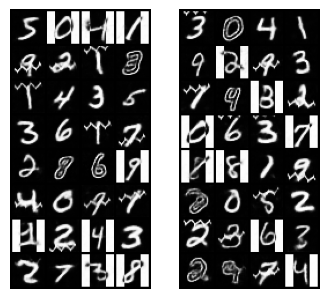

tensor([[14.3000,  2.5100,  4.7200,  3.6400],
        [ 4.6300,  6.2100, 22.1600,  5.8300],
        [ 5.5500,  6.7300,  5.8800, 14.5000],
        [17.0200,  4.5900, 19.2800,  2.5300],
        [15.1200,  8.6100, 17.5900,  8.0000],
        [21.3300,  2.9000, 14.9800, 16.1400],
        [14.1600, 11.3700, 16.7700,  8.5100],
        [ 8.1400,  8.6500, 10.9100, 21.0100]], device='cuda:0')
tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 1, 0],
        [0, 0, 1, 1]], device='cuda:0')
tensor([[31.4000, 67.0300, 61.4100, 63.4800],
        [34.7300, 36.2500,  9.8600, 58.0900],
        [13.4700, 44.8000, 64.0900, 24.8900],
        [53.9900, 28.1700, 12.5700, 26.0300],
        [64.4800, 64.7000, 75.1400, 30.9500],
        [90.4600,  9.7600, 12.7100, 27.5300],
        [39.3400, 20.3300,  7.7200, 10.7300],
        [75.3700, 37.0500, 37.0200, 13.0200]], device='cuda:0')
tensor([[1, 1, 1, 1],
        [1, 

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))
axs[0].imshow(make_grid(Xb_hat, nrow=4).cpu().permute(1, 2, 0))
axs[0].axis("off")
axs[1].imshow(make_grid(Xp_hat, nrow=4).cpu().permute(1, 2, 0))
axs[1].axis("off")
plt.show()
torch.set_printoptions(sci_mode=False)
with torch.no_grad():
    print(
        divergence_fn(
            latent_params_b["mu_c"],
            latent_params_p["mu_c"],
            latent_params_b["logvar_c"],
            latent_params_p["logvar_c"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_c.reshape(-1, 4))

    print(
        divergence_fn(
            latent_params_b["mu_s"],
            latent_params_p["mu_s"],
            latent_params_b["logvar_s"],
            latent_params_p["logvar_s"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_s.reshape(-1, 4))

In [181]:
from src.model import interpolate_latent

### same content but different style

In [178]:
with torch.no_grad():
    idx = 1
    z1, z2 = z_b[1], z_p[1]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))


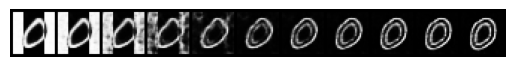

In [180]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

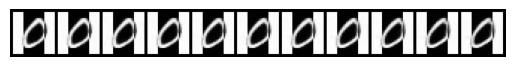

In [182]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

### different contents but the same styles (squiggle lines differ in possible)

In [183]:
with torch.no_grad():
    idx = 31
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))


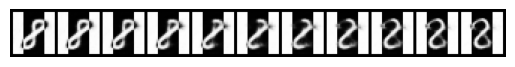

In [184]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

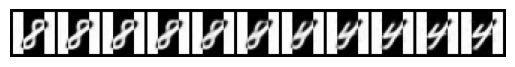

In [185]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

### different contents and different styles

In [192]:
with torch.no_grad():
    idx = 12
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))


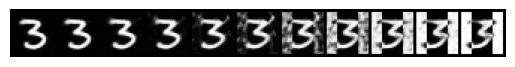

In [193]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

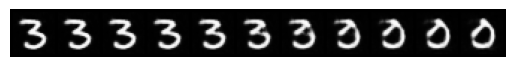

In [194]:
with torch.no_grad():
    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

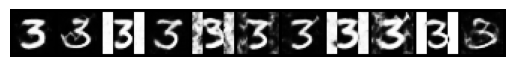

In [197]:
with torch.no_grad():
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), torch.randn(11, 16).to(device)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()